In [2]:
# IMPORTS
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# READ-IN CLEAN ARC DATAFRAME
filename = 'MEBL3_Bias_All_Data_Clean'
bias_df = pd.read_csv(filename, parse_dates=["Time"])    
print(f"{filename} : file read into a pandas dataframe.")
bias_df

MEBL3_Bias_All_Data_Clean : file read into a pandas dataframe.


,Time,B2 Bias,B3 Bias,B4 Bias,C2 Bias,C3 Bias,C4 Bias,D2 Bias,D3 Bias,D4 Bias
0,2024-06-14 01:55:12,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-06-14 01:55:13,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN
2,2024-06-14 01:55:14,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,2024-06-14 01:55:15,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-06-14 01:55:16,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...
1059403,2024-06-27 23:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081
1059404,2024-06-27 23:59:55,0.038,NaN,NaN,NaN,NaN,0.194,NaN,0.031,0.075
1059405,2024-06-27 23:59:56,NaN,NaN,NaN,0.044,NaN,NaN,NaN,0.038,NaN
1059406,2024-06-27 23:59:57,NaN,NaN,0.019,0.038,NaN,0.188,NaN,0.031,0.081


In [4]:
def time_window_filter(timestamp, window_df, window_seconds = 5):
    timestamp = pd.to_datetime(timestamp)
    bias_df['Time_diff'] = (window_df['Time'] - timestamp).abs()
    filtered_df = bias_df[bias_df['Time_diff'] <= pd.Timedelta(seconds=window_seconds)]
    filtered_df = filtered_df.drop(columns=['Time_diff'])
    filtered_df
    return filtered_df

In [5]:
def system_column_filter(sys_col, window_df):
    '''Identifies proper columns from the bias_df dataframe to keep based on input to the sys_col variable
            ex: if B2 inputted, keep B2 measurements, if [C2, C3, C4] inputted, keep C2 + C3 + C4 measurements
    '''
    sys_col_identified_keep_vars = ["Time"]
    if type(sys_col) != list: # one input
        sys_col = [sys_col]
    try:
        # find matching dataframe columns
        for i in range(1, len(window_df.columns)):   # skip Time variable
            df_column = window_df.columns[i]
            try:
                variable_sys_col = df_column[:2]
                if variable_sys_col in sys_col:
                    #print(f"{df_column:<20}{'Match (Keep)':>20}")
                    sys_col_identified_keep_vars.append(df_column)
                else:
                    #print(f"{df_column:<20}{'No Match':>20}")
                    continue
            except:
                print(f"Error... {window_df.columns[i]}")
                continue
        window_df = window_df[sys_col_identified_keep_vars]
    except:     # cannot find matching system column (not B-D, 2-4)
        print(f"{'Invalid input to sys_col parameter':<20}{sys_col:>20}")
        return
    return window_df

In [6]:
def bias_window(timestamp, system_column = None):
    '''Grabs a 10 second time frame surrounding an arc event
        inputs: can be the system column and/or the column component
        timestamp parameter: keeps rows in which Time is within 10 seconds of arc event (timestamp input) (row axis filter)
        sys_col and pressure_type: keep columns matching desired inputs (column axis filter)
    '''
    window_df = bias_df.copy(deep=True)
    if type(system_column) != list: system_column = [system_column]
    # row axis filter
    timestamp = pd.to_datetime(timestamp)
    window_df = time_window_filter(timestamp, window_df)
    if window_df.empty: print(f"{timestamp} has no data, implying the system was turned off at that time")
    # column axis filter
    if system_column is not None:
        window_df = system_column_filter(system_column, window_df)
    # PLOT WINDOW    
    # First, plot all system columns on same graph
    plt.figure(figsize=(12, 6))
    plot_df = window_df.copy(deep=True)
    plot_df.columns = [x[:2] for x in plot_df.columns]
    plot_df = plot_df.rename(columns = {"Ti": "Time"})
    plot_df = plot_df.melt(id_vars="Time", value_vars=system_column, var_name="System Column", value_name="Bias")
    plot = sns.lineplot(data=plot_df, x="Time", y="Bias", hue = 'System Column')
    title = ', '.join(str(x) for x in system_column) + " Bias"
    plot.set_title(f"{title}")
    plot.set_ylabel("Bias Current")
    time_ticks = plot_df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    plot.set_xticks(plot_df["Time"])
    plot.set_xticklabels(time_ticks, rotation = 30)
    plt.show()
    # Second, make one plot for each system column
    for sys_col in system_column:
        plt.figure(figsize=(12,6))
        col_name = sys_col + " Bias"
        plot_df = window_df[["Time", col_name]]
        plot = sns.lineplot(data=plot_df, x="Time", y=col_name)
        time_ticks = plot_df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        plot.set_title(f"{col_name}")
        plot.set_ylabel("Bias Current")
        plot.set_xticks(plot_df["Time"])
        plot.set_xticklabels(time_ticks, rotation = 60)
        plt.show()
    return window_df

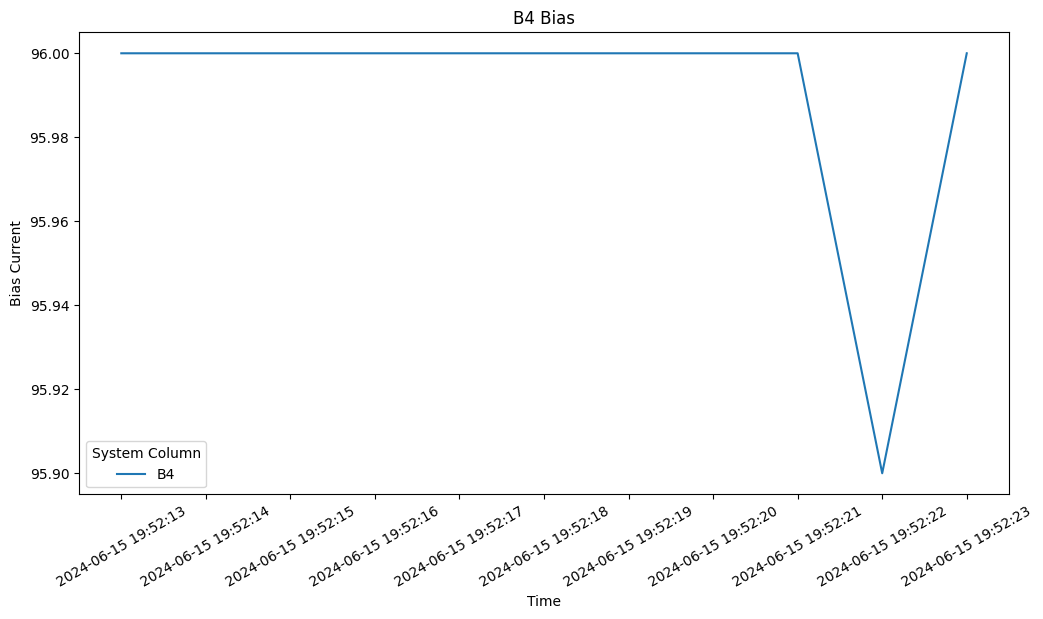

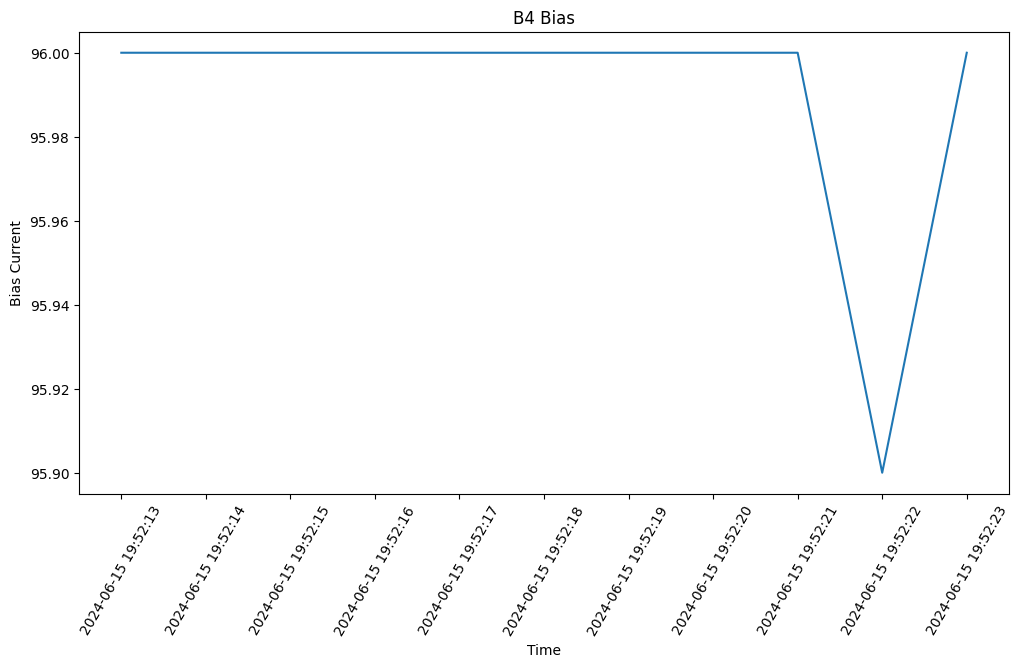

,Time,B4 Bias
144243,2024-06-15 19:52:13,96.0
144244,2024-06-15 19:52:14,96.0
144245,2024-06-15 19:52:15,NaN
144246,2024-06-15 19:52:16,NaN
144247,2024-06-15 19:52:17,NaN
144248,2024-06-15 19:52:18,NaN
144249,2024-06-15 19:52:19,NaN
144250,2024-06-15 19:52:20,96.0
144251,2024-06-15 19:52:21,96.0
144252,2024-06-15 19:52:22,95.9


In [7]:
bias_window('2024-06-15 19:52:18', ["B4"])

### How much of a % change in Bias current is considered an arc event? If arc threshold is small, then change may not be obvious on chart when scale is spread out (which happens when multiple different systems are graphed together, thus would warrant a change from a singular multiplot to multiple single-lineplots)